In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter1d

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# 被験者ID
subject_id = "001"
# 実験番号
experiment_id = "001"

# IDT法のパラメータ
DISPERSION_THRESHOLD = 1.0  # deg
DURATION_THRESHOLD_MS = 100  # ms

eye_df = pd.read_csv(f"exported_csv/eye_df_id{subject_id}-{experiment_id}.csv")
sampling_df = pd.read_csv(f"exported_csv/sampling_df_id{subject_id}-{experiment_id}.csv")

In [65]:

# モニターサイズ(物理)
monitor_width_cm = 47.6
monitor_height_cm = 26.8
# モニター解像度(px)
monitor_resolution_px = (1920, 1080)
# 視距離(cm)
viewer_distance_cm = 70.0

# cm/pxの変換係数
cm_per_pixel_x = monitor_width_cm / monitor_resolution_px[0]
cm_per_pixel_y = monitor_height_cm / monitor_resolution_px[1]

# ディスプレイ中心を(0, 0)とするための変換
eye_df["gx_centered"] = eye_df["gx"] - 0.5
eye_df["gy_centered"] = eye_df["gy"] - 0.5

# 中心(0,0)での物理距離変換
eye_df["x_cm"] = eye_df["gx_centered"] * monitor_resolution_px[0] * cm_per_pixel_x
eye_df["y_cm"] = eye_df["gy_centered"] * monitor_resolution_px[1] * cm_per_pixel_y

# 視野角の計算
eye_df["x_deg"] = np.degrees(np.arctan2(eye_df["x_cm"], viewer_distance_cm))
eye_df["y_deg"] = np.degrees(np.arctan2(eye_df["y_cm"], viewer_distance_cm))

# データの有効性
eye_df["is_valid"] = eye_df["validity_sum"] > 1

print(eye_df.head())


         gx        gy     epoch_sec        hhmmss  validity_sum  trial  \
0       NaN       NaN  1.732521e+09  16:49:03.491             0     -1   
1  0.476050  0.816155  1.732521e+09  16:49:03.506             2     -1   
2  0.490610  0.818481  1.732521e+09  16:49:03.522             2     -1   
3  0.520527  0.754540  1.732521e+09  16:49:03.538             2     -1   
4  0.507679  0.780874  1.732521e+09  16:49:03.538             2     -1   

   gx_centered  gy_centered      x_cm      y_cm     x_deg     y_deg  is_valid  
0          NaN          NaN       NaN       NaN       NaN       NaN     False  
1    -0.023950     0.316155 -1.140020  8.472954 -0.933037  6.901632      True  
2    -0.009390     0.318481 -0.446964  8.535291 -0.365840  6.951913      True  
3     0.020527     0.254540  0.977085  6.821672  0.799703  5.566039      True  
4     0.007679     0.280874  0.365520  7.527423  0.299180  6.137694      True  


In [66]:
def interpolate_missing(df, time_col="epoch_sec", max_gap_ms=100):
    df= df.copy()
    df["valid"]= df["is_valid"]
    df["interp_x"]= np.nan
    df["interp_y"]= np.nan

    # 有効データを代入
    df.loc[df["valid"], "interp_x"] = df.loc[df["valid"], "x_deg"]
    df.loc[df["valid"], "interp_y"] = df.loc[df["valid"], "y_deg"]
    
    # 内部のみ線形補完
    df["interp_x"] = df["interp_x"].interpolate(limit_area="inside")
    df["interp_y"] = df["interp_y"].interpolate(limit_area="inside")
    
    # 無効区間の連続ブロックを取得
    invalid_mask = ~df["valid"]
    group_id = (invalid_mask != invalid_mask.shift()).cumsum()
    invalid_blocks = df[invalid_mask].groupby(group_id)

    for _, block in invalid_blocks:
        if len(block) == 0:
            continue
        t_start = block[time_col].iloc[0]
        t_end = block[time_col].iloc[-1]
        duration_ms = (t_end - t_start) * 1000
        if duration_ms > max_gap_ms:
            # 100ms超えたら補完結果をNaNに戻す
            df.loc[block.index, ["interp_x", "interp_y"]] = np.nan
    

    return df
    
    

In [67]:
def apply_gaussian_filter_by_block(df, col_x="x_deg", col_y="y_deg", sigma=1.0):
    df = df.copy()
    df["valid"]= df["is_valid"]
    df["filtered_x"] = np.nan
    df["filtered_y"] = np.nan

    # 有効なデータ（NaNでない）だけを連続ブロックとして抽出
    valid_mask = df[col_x].notna() & df[col_y].notna()
    block_id = (valid_mask != valid_mask.shift()).cumsum()
    blocks = df[valid_mask].groupby(block_id)

    for _, block in blocks:
        idx = block.index
        smoothed_x = gaussian_filter1d(block[col_x], sigma=sigma)
        smoothed_y = gaussian_filter1d(block[col_y], sigma=sigma)
        df.loc[idx, "filtered_x"] = smoothed_x
        df.loc[idx, "filtered_y"] = smoothed_y

    return df


In [68]:
def detect_fixations_idt(df, dispersion_threshold=DISPERSION_THRESHOLD, duration_threshold_ms=DURATION_THRESHOLD_MS):
    fixations = []
    timestamps = df["epoch_sec"].to_numpy()
    xs = df["filtered_x"].to_numpy()
    ys = df["filtered_y"].to_numpy()
    
    i = 0
    while i < len(df):
        if np.isnan(xs[i]) or np.isnan(ys[i]):
            i += 1
            continue

        window = [(xs[i], ys[i])]
        t_start = timestamps[i]
        j = i + 1

        while j < len(df):
            if np.isnan(xs[j]) or np.isnan(ys[j]):
                break

            window.append((xs[j], ys[j]))
            t_end = timestamps[j]
            duration = (t_end - t_start) * 1000

            x_vals, y_vals = zip(*window)
            x_center = np.mean(x_vals)
            y_center = np.mean(y_vals)
            distances = np.sqrt((np.array(x_vals) - x_center)**2 + (np.array(y_vals) - y_center)**2)

            if np.max(distances) > dispersion_threshold:
                break

            j += 1

        # 注視条件を満たしていれば1つだけ追加
        if (timestamps[j - 1] - t_start) * 1000 >= duration_threshold_ms:
            x_vals, y_vals = zip(*window)
            fixations.append({
                "start_time": t_start,
                "end_time": timestamps[j - 1],
                "duration_ms": (timestamps[j - 1] - t_start) * 1000,
                "x_mean_deg": np.mean(x_vals),
                "y_mean_deg": np.mean(y_vals),
            })

        i = j  # 次の未使用インデックスに進む

    return pd.DataFrame(fixations)
    

In [69]:
def deg_to_px(x_deg, y_deg):
    x_cm = np.tan(np.radians(x_deg)) * viewer_distance_cm
    y_cm = np.tan(np.radians(y_deg)) * viewer_distance_cm
    
    x_px = (x_cm / cm_per_pixel_x) + (monitor_resolution_px[0] / 2)
    y_px = (y_cm / cm_per_pixel_y) + (monitor_resolution_px[1] / 2)
    
    return x_px, y_px
    

**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   188.999891   -2.189313   -0.065205    0.0   
1   1.732521e+09  1.732521e+09   286.000013   -0.281548    0.185698    0.0   
2   1.732521e+09  1.732521e+09   128.000021   -0.722083    0.325825    0.0   
3   1.732521e+09  1.732521e+09   414.000034   -0.553004    0.186376    0.0   
4   1.732521e+09  1.732521e+09   285.000086   -1.480517    0.423346    0.0   
..           ...           ...          ...         ...         ...    ...   
81  1.732521e+09  1.732521e+09   335.000038   -4.315844   -7.661365    0.0   
82  1.732521e+09  1.732521e+09   239.000082   -2.615146   -9.107711    0.0   
83  1.732521e+09  1.732521e+09   240.000010   -5.314049   -7.935455    0.0   
84  1.732521e+09  1.732521e+09   207.000017   -6.264321   -7.237340    0.0   
85  1.732521e+09  1.732521e+09   319.000006   -6.303581   -6.440523    0.0   

          x_px        y_

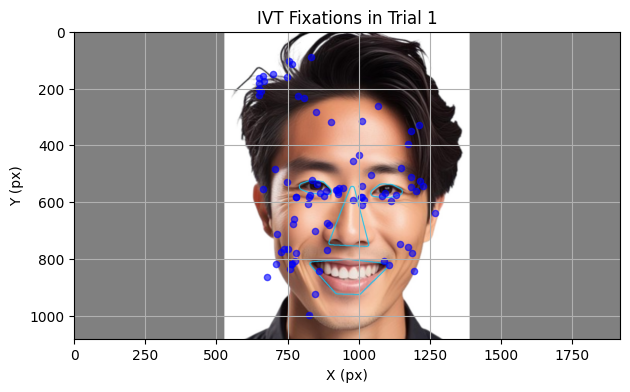

**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   493.999958   -0.097709    0.234435    1.0   
1   1.732521e+09  1.732521e+09   240.000010   -0.362702    1.425444    1.0   
2   1.732521e+09  1.732521e+09   111.999989   -2.985384    1.593320    1.0   
3   1.732521e+09  1.732521e+09   111.000061   -2.912093    1.901966    1.0   
4   1.732521e+09  1.732521e+09   457.999945   -0.119587    0.309727    1.0   
..           ...           ...          ...         ...         ...    ...   
72  1.732521e+09  1.732521e+09   159.000158   -1.801721    3.554769    1.0   
73  1.732521e+09  1.732521e+09   588.000059   -0.007392    4.826576    1.0   
74  1.732521e+09  1.732521e+09   111.999989    0.290792    5.521738    1.0   
75  1.732521e+09  1.732521e+09   223.999977   -2.189891    0.925766    1.0   
76  1.732521e+09  1.732521e+09   414.999962   -1.501529    0.602236    1.0   

          x_px        y_

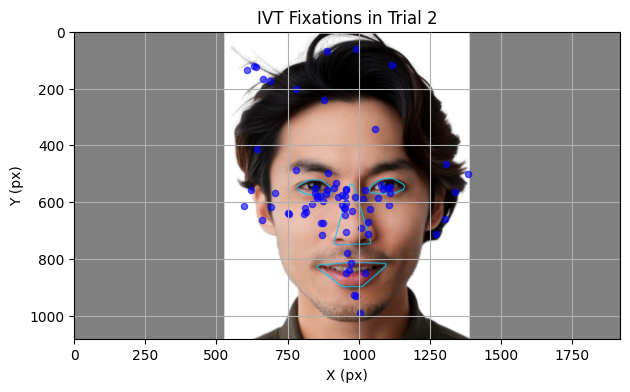

**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   128.000021   -0.003327    0.748034    2.0   
1   1.732521e+09  1.732521e+09   126.000166   -6.189197    1.443675    2.0   
2   1.732521e+09  1.732521e+09   271.000147   -1.369937    1.166772    2.0   
3   1.732521e+09  1.732521e+09   128.000021    0.263696    0.379493    2.0   
4   1.732521e+09  1.732521e+09   319.000006   -0.181935    0.295041    2.0   
..           ...           ...          ...         ...         ...    ...   
72  1.732521e+09  1.732521e+09   398.999929   -4.395876   -7.315481    2.0   
73  1.732521e+09  1.732521e+09   253.999949   -7.281937   -3.059023    2.0   
74  1.732521e+09  1.732521e+09   222.999811   -5.555759    0.150524    2.0   
75  1.732521e+09  1.732521e+09   509.999990    0.731704    5.447399    2.0   
76  1.732521e+09  1.732521e+09   300.999880    1.119726    6.113376    2.0   

           x_px        y

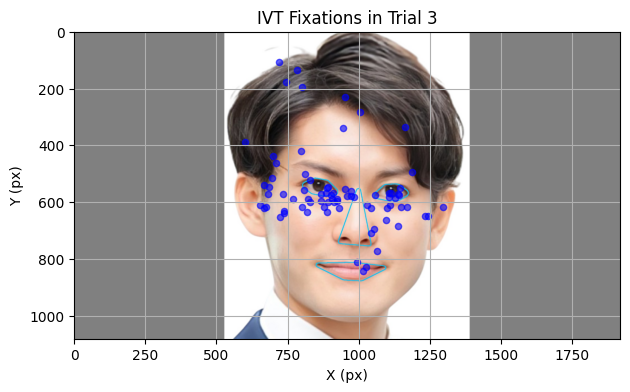

**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   190.999985   -0.570894    0.337975    3.0   
1   1.732521e+09  1.732521e+09   697.999954    0.292938    0.198507    3.0   
2   1.732521e+09  1.732521e+09   144.000053    0.767939    1.125245    3.0   
3   1.732521e+09  1.732521e+09   144.000053   -2.659019    0.943306    3.0   
4   1.732521e+09  1.732521e+09   634.999990   -0.562101    0.776162    3.0   
..           ...           ...          ...         ...         ...    ...   
72  1.732521e+09  1.732521e+09   125.999928    8.036405   -0.604233    3.0   
73  1.732521e+09  1.732521e+09   223.999977    8.023758    0.734783    3.0   
74  1.732521e+09  1.732521e+09   319.999933    6.554178    0.047502    3.0   
75  1.732521e+09  1.732521e+09   697.999954   -6.794238    1.185124    3.0   
76  1.732521e+09  1.732521e+09   623.000145   -7.345173    0.032593    3.0   

           x_px        y

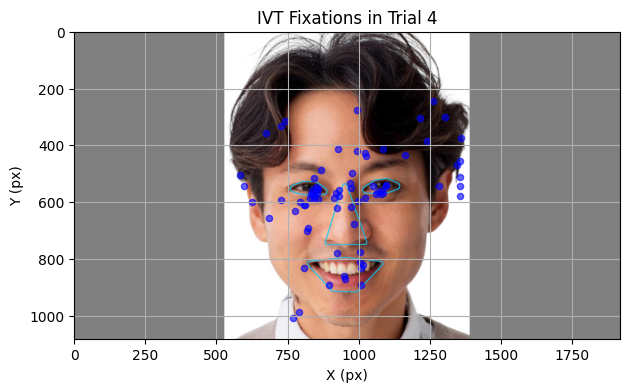

**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   191.999912   -0.192024    0.644979    4.0   
1   1.732521e+09  1.732521e+09   526.999950    3.384255    0.563907    4.0   
2   1.732521e+09  1.732521e+09   510.999918    7.268739    1.904587    4.0   
3   1.732521e+09  1.732521e+09   207.999945    7.481980    1.204538    4.0   
4   1.732521e+09  1.732521e+09   460.999966    6.999902    0.883850    4.0   
..           ...           ...          ...         ...         ...    ...   
67  1.732521e+09  1.732521e+09   303.999901   -1.156653    1.778829    4.0   
68  1.732521e+09  1.732521e+09   175.999880   -0.733067    0.998345    4.0   
69  1.732521e+09  1.732521e+09   269.999981    3.671864    1.523462    4.0   
70  1.732521e+09  1.732521e+09   207.000017    6.839804    0.839239    4.0   
71  1.732521e+09  1.732521e+09   142.999887   -6.779633    0.826762    4.0   

           x_px        y

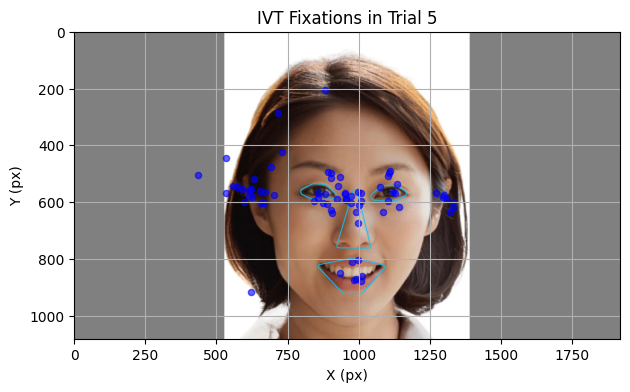

**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   285.000086   -2.768341    1.254454    5.0   
1   1.732521e+09  1.732521e+09   282.999992    0.258543    0.507960    5.0   
2   1.732521e+09  1.732521e+09   144.000053   -0.098446    1.387937    5.0   
3   1.732521e+09  1.732521e+09   158.999920   -2.351670    1.369766    5.0   
4   1.732521e+09  1.732521e+09   300.999880   -0.871766    0.707921    5.0   
..           ...           ...          ...         ...         ...    ...   
77  1.732521e+09  1.732521e+09   509.000063   -1.604254    0.185217    5.0   
78  1.732521e+09  1.732521e+09   239.000082   -2.418526    1.339918    5.0   
79  1.732521e+09  1.732521e+09   335.999966   -2.276919    0.806642    5.0   
80  1.732521e+09  1.732521e+09   463.999987   -2.286738    0.380001    5.0   
81  1.732521e+09  1.732521e+09   240.000010    1.545264    1.317809    5.0   

           x_px        y

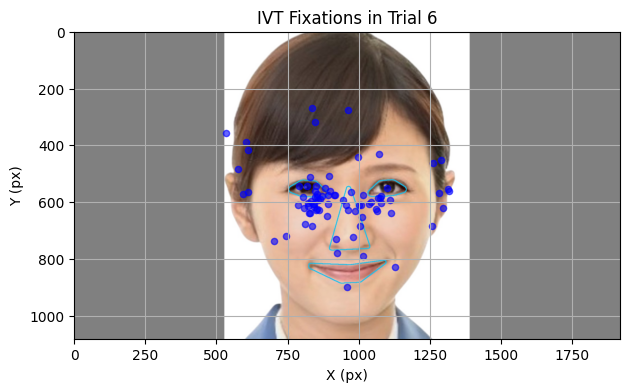

**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   144.000053   -0.545615    1.355802    6.0   
1   1.732521e+09  1.732521e+09   830.000162   -0.310336    0.543513    6.0   
2   1.732521e+09  1.732521e+09   397.000074    0.204494    0.439497    6.0   
3   1.732521e+09  1.732521e+09   240.000010   -0.712687    0.430151    6.0   
4   1.732521e+09  1.732521e+09   238.000154   -0.553131    0.517008    6.0   
..           ...           ...          ...         ...         ...    ...   
77  1.732521e+09  1.732521e+09   319.999933   -7.224511   -1.046511    6.0   
78  1.732522e+09  1.732522e+09   208.000183   -4.886649    1.180954    6.0   
79  1.732522e+09  1.732522e+09   349.999905    2.688923    1.754631    6.0   
80  1.732522e+09  1.732522e+09   270.999908    2.270793    5.589698    6.0   
81  1.732522e+09  1.732522e+09   111.999989   -1.172840    3.263353    6.0   

           x_px        y

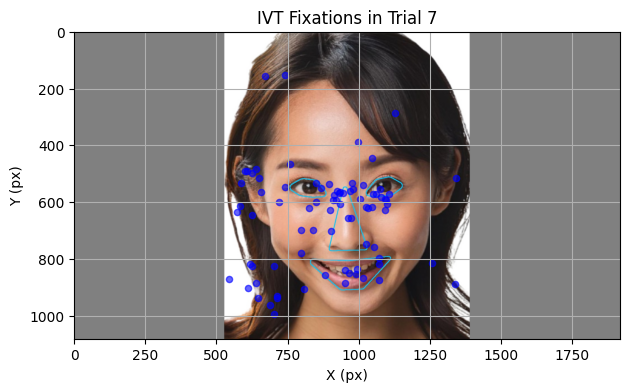

**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732522e+09  1.732522e+09   203.999996   -0.736109    0.577480    7.0   
1   1.732522e+09  1.732522e+09   414.999962   -3.153842    2.651874    7.0   
2   1.732522e+09  1.732522e+09   333.999872   -0.279927    0.472258    7.0   
3   1.732522e+09  1.732522e+09   126.999855    0.276035    0.670723    7.0   
4   1.732522e+09  1.732522e+09   156.999826    9.508756    5.739683    7.0   
..           ...           ...          ...         ...         ...    ...   
70  1.732522e+09  1.732522e+09   143.000126   -8.832026    1.831140    7.0   
71  1.732522e+09  1.732522e+09   174.999952   -2.733799    0.833961    7.0   
72  1.732522e+09  1.732522e+09   142.999887   -5.848922   -0.222622    7.0   
73  1.732522e+09  1.732522e+09   128.000021   -1.116727    0.886055    7.0   
74  1.732522e+09  1.732522e+09   157.999992   -1.304025    0.195174    7.0   

           x_px        y

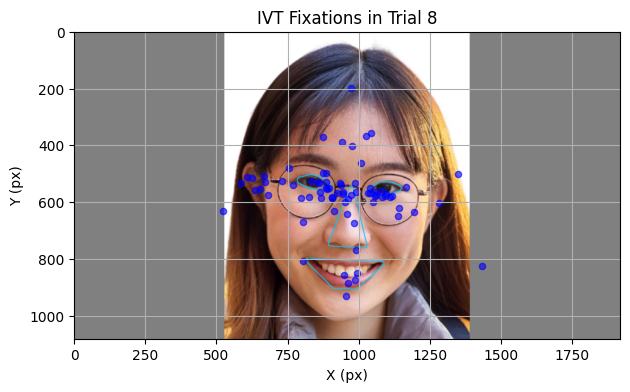

In [70]:
# === トライアルごとの処理 + プロット ===
all_fixations = []

for _, row in sampling_df.iterrows():
    t_start = row["start_sec"]
    t_end = row["end_sec"]
    trial_num = row["trial"]

    df_trial = eye_df[(eye_df["epoch_sec"] >= t_start) & (eye_df["epoch_sec"] <= t_end)]
    df_interp = interpolate_missing(df_trial)
    df_filtered= apply_gaussian_filter_by_block(df_interp)
    fix_df = detect_fixations_idt(df_filtered, DISPERSION_THRESHOLD, DURATION_THRESHOLD_MS)
    
    if fix_df.empty:
        print(f"Trial {trial_num}: No fixations detected.")
        continue
    
    fix_df["trial"] = trial_num
    fix_df["x_px"], fix_df["y_px"] = deg_to_px(fix_df["x_mean_deg"], fix_df["y_mean_deg"])
    all_fixations.append(fix_df)
    
    print("**************************************")
    
    print(fix_df)
    print(len(fix_df))

# 背景画像を読み込み
    img = mpimg.imread(f"output_aoi/1-{int(trial_num)+1}.jpg")  # 例: "background.png"

    # 図の作成
    fig, ax = plt.subplots()

    # 背景画像の表示（軸にフィットさせて）
    ax.imshow(img, extent=[0, 1920, 1080, 0])  # 上下反転（y軸を上→下に）

    # 散布図の描画（fix_dfは事前に用意）
    ax.scatter(fix_df["x_px"], fix_df["y_px"], alpha=0.6, c='blue', s=20)

    # 軸設定（アスペクト比保持）
    ax.set_xlim(0, 1920)
    ax.set_ylim(1080, 0)  # y軸を反転
    ax.set_box_aspect(1080 / 1920)  # 縦横比を固定

    # ラベルや装飾
    ax.set_title(f"IVT Fixations in Trial {int(trial_num + 1)}")
    ax.set_xlabel("X (px)")
    ax.set_ylabel("Y (px)")
    ax.grid(True)

    # レイアウト調整＆表示
    plt.tight_layout()
    plt.show()



    

In [71]:
# new1_df=interpolate_missing(eye_df)
# # print(new1_df.head())
# new2_df=apply_gaussian_filter_by_block(new1_df)
# new3_df=detect_fixations_idt(new2_df)
# deg_to_px(new3_df["x_mean_deg"], new3_df["y_mean_deg"])